In [2]:
!pip install graphviz==0.9
!pip install pydot

In [3]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [4]:
#vendido é nossa classe, e as outras variáveis (features) que vamos analisar.

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]

SEED = 158020
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify=y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 7500 elementos e testaremos com 2500 elementos


In [5]:
#antes de rodar o classificador, precisamos decidir o que é uma taxa de acerto aceitável, boa e ruim.
#o dummy classifier é estratificado, ele pega o que temos de experiência e usa isso.

from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
acuracia = dummy_stratified.score(teste_x, teste_y) * 100

print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

A acurácia do dummy stratified foi 58.00%


In [6]:
#vamos rodar uma árvore de decisão

from sklearn.tree import DecisionTreeClassifier

SEED = 158020
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

A acurácia do dummy stratified foi 71.92%


In [7]:
# observando a diferença da acurácia de acordo com o SEED utilizado
# não podemos basear uma decisão numa aleatoriedade e precisamos minimizar esse risco
# precisamos treinar mais de uma vez o modelo para ter uma estimativa (um intervalo)

x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]

SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify=y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo = DecisionTreeClassifier(max_depth=2)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia do dummy stratified foi 76.84%


In [8]:
# cross validation - separa os dados em k pedaços e rodar k testes com cada um deles e aí faz a média dos resultados (k fold)
# como a média é um ponto que não necessariamente descreve bem os dados, usamos um intervalo
# escolher um número k (leave one out) pode ser mais lento o processamento, mas entrega uma medida mais realista.

from sklearn.model_selection import cross_validate

SEED = 301
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x, y, cv = 3, return_train_score= False)
media = resultados['test_score'].mean()
desvio_padrao = resultados['test_score'].std()
print("Accuracy com cross validation, 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 3 = [74.99, 76.57]


In [9]:
# com a cross validation a gente tira o peso do SEED, porém ainda temos a influência do cv = 3 - quantidade de pedaços
# de acordo com papers, uma escolha de k entre 5 e 10 já é o suficiente.

SEED = 301
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x, y, cv = 5, return_train_score= False)
media = resultados['test_score'].mean()
desvio_padrao = resultados['test_score'].std()
print("Accuracy com cross validation, 5 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 5 = [75.21, 76.35]


# Aleatoriedade no cross validade

O cross_validate() não recebe o parâmetro de aleatoriedade, e esse é o padrão. Da maneira utilizada por nós, ele é determinístico, e nós sabemos em quantos pedaços ele quebrará os dados, porque somos nós quem decidimos essa quantidade. Portanto, a realidade é que a aleatoriedade (random) só é aplicada em DecisionTreeClassifier(). E, por padrão, ele só a usará em um caso específico e raro. Por estas razões, mesmo que mudemos constantemente o valor de SEED, obteremos basicamente sempre os mesmos números. <br>


In [10]:
def imprime_resultados(resultados):
    media = resultados['test_score'].mean()
    desvio_padrao = resultados['test_score'].std()
    print("Accuracy médio: %.2f" % (media * 100))
    print("Accuracy intervalo: [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

In [11]:
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

cv = KFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x, y, cv = cv, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 75.78
Accuracy intervalo: [74.37, 77.19]


In [12]:
SEED = 301
np.random.seed(SEED)

cv = KFold(n_splits=10, shuffle=True)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x, y, cv = cv, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 75.76
Accuracy intervalo: [73.26, 78.26]


# Simular situação horrível de azar

Pode ser "azar" como pode ser uma proporção de exemplos desbalanceados entre as classes.

In [13]:
dados_azar = dados.sort_values("vendido", ascending= True)

x_azar = dados_azar[["preco", "idade_do_modelo", "km_por_ano"]]
y_azar = dados_azar["vendido"]

dados_azar.head()


,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [14]:
SEED = 301
np.random.seed(SEED)

cv = KFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 57.84
Accuracy intervalo: [34.29, 81.39]


In [15]:
SEED = 301
np.random.seed(SEED)

cv = KFold(n_splits=10, shuffle=True)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 75.78
Accuracy intervalo: [72.30, 79.26]


In [16]:
from sklearn.model_selection import StratifiedKFold

SEED = 301
np.random.seed(SEED)

cv = StratifiedKFold(n_splits=10, shuffle=True)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 75.78
Accuracy intervalo: [73.55, 78.01]


# Validação cruzada usando grupos

Gerando dados aleatórios de modelo de carro para simulação de agrupamenteo ao usar o estimador


In [17]:
# é preciso tomar cuidado quando formos separar treino e teste, quando nós testamos, temos que ser capazes de testar como se fosse no mundo real
# se nos treinos e testes temos repetições, é possível que o algoritmo não generalize bem para novos carros, pacientes, etc.
# na hora de separar treino e teste, teríamos que agrupar por modelos e pacientes - então pegamos uma CARACTERÍSTICA DE AGRUPAMENTO e tentamos trabalhar nos nossos dados.

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [18]:
dados.modelo.unique()

array([18, 24, 14,  6,  5, 13, 20, 19, 15,  2, 17, 12, 11, 16,  3,  7, 21,
       23, 10,  9, 22,  8,  4,  1], dtype=int64)

In [19]:
dados.modelo.value_counts()

modelo
20    901
19    798
18    771
21    723
17    709
16    668
14    621
22    575
15    573
13    557
12    511
11    401
10    371
23    370
9     336
8     278
7     206
24    199
6     181
5     108
4      76
3      44
2      17
1       6
Name: count, dtype: int64

## Testando a validação cruzada com GroupKFold

In [20]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)


cv = StratifiedKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 75.78
Accuracy intervalo: [73.83, 77.73]


## Cross Validation com StandardScaler

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#o modelo não usa o seed no scaler, mas o SVC sim
SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
scaler.fit(treino_x)
treino_x_escalado = scaler.transform(treino_x)
teste_x_escalado = scaler.transform(teste_x)

modelo = SVC()
modelo.fit(treino_x_escalado, treino_y)
previsoes = modelo.predict(teste_x_escalado)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 77.48%


In [22]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = SVC()
resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 77.27
Accuracy intervalo: [74.35, 80.20]


In [23]:
scaler = StandardScaler()
scaler.fit(x_azar)
x_azar_escalado = scaler.transform(x_azar)

In [24]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
modelo = SVC()
resultados = cross_validate(modelo, x_azar_escalado, y_azar, cv = cv, groups = dados.modelo, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 76.70
Accuracy intervalo: [74.30, 79.10]


In [25]:
# o fit() acontece mais de uma vez porque temos dez separações baseadas nos grupos, para treinar e testar
# o que acontece então é um processo de duas fases: 1- pré-processamento que escala e, 2- validação
# esse processo deve ser rodado várias vezes, de acordo com nossos grupos e splits por isso criamos a sequência de passos (pipeline)
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao', scaler), ('estimador', modelo)])

cv = GroupKFold(n_splits=10)
resultados = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 76.68
Accuracy intervalo: [74.28, 79.08]


## Treinando o modelo final

A ideia é que a validação cruzada num conjunto de dados somente te diz o que você pode esperar. Ela não treina o seu modelo final.<br>
O resultado do cross_validate indica o que você deve esperar. Para obter o modelo final, basta treiná-lo em todos os dados que você usou para o crossvalidation e depois o modelo estará pronto para usar com o predict e classificar dados novos.


In [26]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)


cv = StratifiedKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=2)
resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 75.78
Accuracy intervalo: [73.83, 77.73]


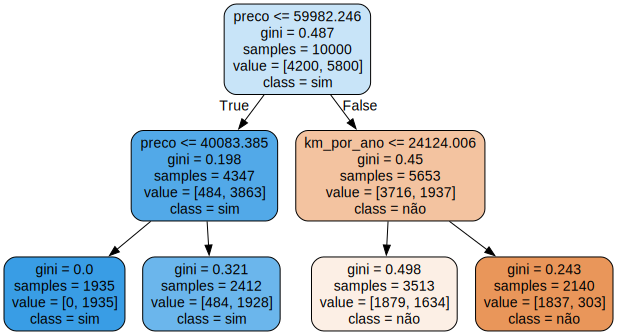

In [29]:
import graphviz
from sklearn.tree import export_graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                class_names=['não', 'sim'],
                feature_names= features)
graph = graphviz.Source(dot_data)
graph

In [30]:
SEED = 301
np.random.seed(SEED)


cv = StratifiedKFold(n_splits=10)
modelo = DecisionTreeClassifier(max_depth=3)
resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= False)
imprime_resultados(resultados)

Accuracy médio: 78.70
Accuracy intervalo: [75.87, 81.53]


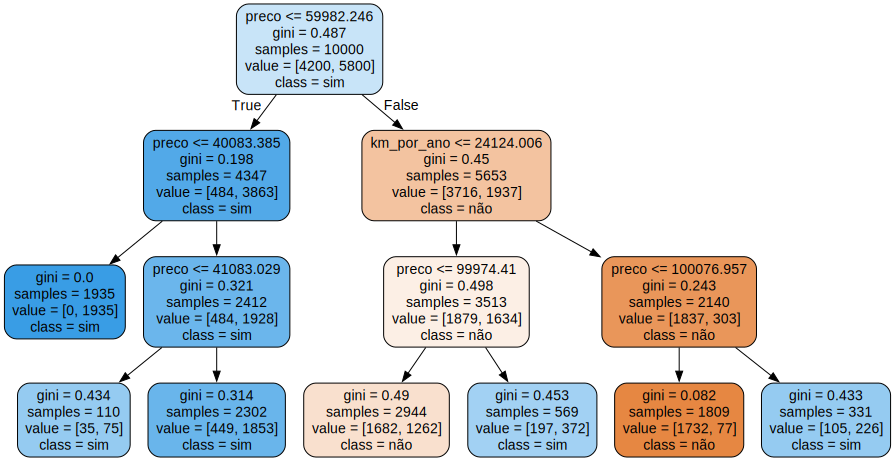

In [31]:
import graphviz
from sklearn.tree import export_graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                class_names=['não', 'sim'],
                feature_names= features)
graph = graphviz.Source(dot_data)
graph

## Testando parâmetros

In [38]:
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)


    cv = StratifiedKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= True)
    train_score = resultados['train_score'].mean() * 100
    test_score = resultados['test_score'].mean() * 100
    print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
    tabela = [max_depth, train_score, test_score]
    return tabela

results = [roda_arvore_de_decisao(i) for i in range(1,33)]
results = pd.DataFrame(results, columns=['max_depth', 'train', 'test'])
results.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.70
Arvore max_depth = 4, treino = 78.80, teste = 78.63
Arvore max_depth = 5, treino = 78.97, teste = 78.56
Arvore max_depth = 6, treino = 79.19, teste = 78.49
Arvore max_depth = 7, treino = 79.44, teste = 78.04
Arvore max_depth = 8, treino = 79.81, teste = 77.83
Arvore max_depth = 9, treino = 80.36, teste = 77.55
Arvore max_depth = 10, treino = 80.99, teste = 77.03
Arvore max_depth = 11, treino = 81.79, teste = 76.30
Arvore max_depth = 12, treino = 82.64, teste = 76.15
Arvore max_depth = 13, treino = 83.56, teste = 75.71
Arvore max_depth = 14, treino = 84.56, teste = 75.40
Arvore max_depth = 15, treino = 85.62, teste = 75.32
Arvore max_depth = 16, treino = 86.75, teste = 75.09
Arvore max_depth = 17, treino = 87.80, teste = 74.92
Arvore max_depth = 18, treino = 88.81, teste = 74.82
Arvore max_depth = 19, treino = 89.85, teste = 74.04
Ar

,max_depth,train,test
0,1,75.791111,75.78
1,2,75.791111,75.78
2,3,78.754444,78.70
3,4,78.800000,78.63
4,5,78.965556,78.56


<Axes: xlabel='max_depth', ylabel='train'>

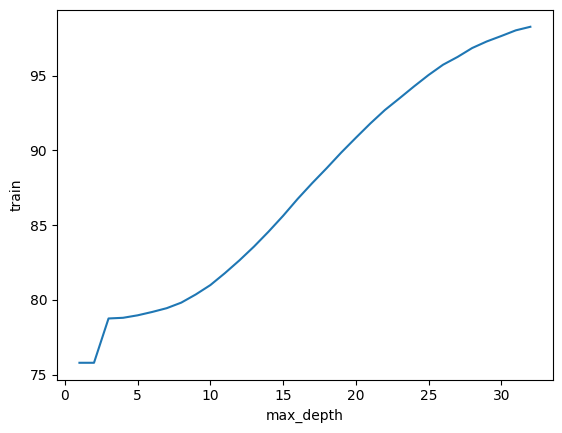

In [39]:
import seaborn as sns

sns.lineplot(data = results, x = "max_depth", y = "train")

### Overfitting: ficou perfeito para o treino e horrível para o teste

<Axes: xlabel='max_depth', ylabel='train'>

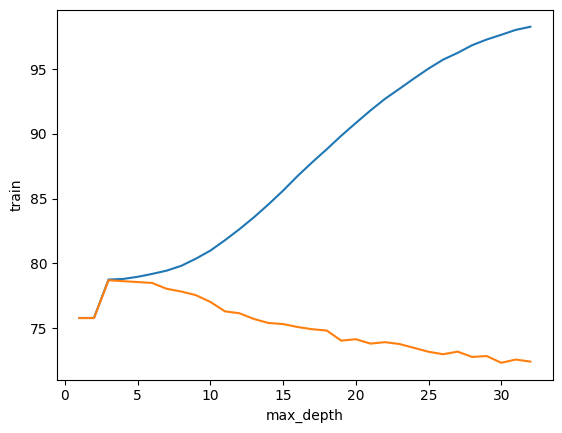

In [40]:
sns.lineplot(data = results, x = "max_depth", y = "train")
sns.lineplot(data = results, x = "max_depth", y = "test")

### Explorando hiper parâmetros com 2 dimensões

In [45]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)


    cv = StratifiedKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= True)
    train_score = resultados['train_score'].mean() * 100
    test_score = resultados['test_score'].mean() * 100
    print("Arvore max_depth = %d, Min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
    tabela = [max_depth, min_samples_leaf,  train_score, test_score]
    return tabela

def busca():
    results = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            results.append(tabela)
    results = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return results

results = busca()
results.head()

Arvore max_depth = 1, Min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, Min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, Min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, Min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, Min_samples_leaf = 32, treino = 78.75, teste = 78.70
Arvore max_depth = 3, Min_samples_leaf = 64, treino = 78.75, teste = 78.70
Arvore max_depth = 3, Min_samples_leaf = 128, treino = 78.75, teste = 78.70
Arvore max_depth = 3, Min_samples_leaf = 256, treino = 78.75, teste = 78.70
Arvore max_depth = 4, Min_samples_leaf = 32, treino = 78.76, teste = 78.65
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791111,75.78
1,1,64,75.791111,75.78
2,1,128,75.791111,75.78
3,1,256,75.791111,75.78
4,2,32,75.791111,75.78


In [46]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
11,3,256,78.752222,78.7
10,3,128,78.752222,78.7
15,4,256,78.752222,78.7
14,4,128,78.752222,78.7
8,3,32,78.752222,78.7


In [48]:
corr = results.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.550863,-0.083410
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.397234,0.509578
train,5.508631e-01,-3.972342e-01,1.000000,0.099320
test,-8.340988e-02,5.095776e-01,0.099320,1.000000


<Axes: >

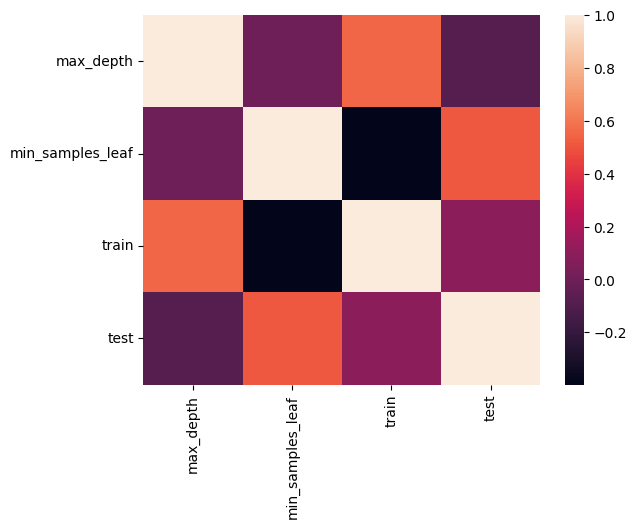

In [49]:
sns.heatmap(corr)

In [51]:
import pandas as pd

array([[<Axes: xlabel='max_depth', ylabel='max_depth'>,
        <Axes: xlabel='min_samples_leaf', ylabel='max_depth'>,
        <Axes: xlabel='train', ylabel='max_depth'>,
        <Axes: xlabel='test', ylabel='max_depth'>],
       [<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <Axes: xlabel='train', ylabel='min_samples_leaf'>,
        <Axes: xlabel='test', ylabel='min_samples_leaf'>],
       [<Axes: xlabel='max_depth', ylabel='train'>,
        <Axes: xlabel='min_samples_leaf', ylabel='train'>,
        <Axes: xlabel='train', ylabel='train'>,
        <Axes: xlabel='test', ylabel='train'>],
       [<Axes: xlabel='max_depth', ylabel='test'>,
        <Axes: xlabel='min_samples_leaf', ylabel='test'>,
        <Axes: xlabel='train', ylabel='test'>,
        <Axes: xlabel='test', ylabel='test'>]], dtype=object)

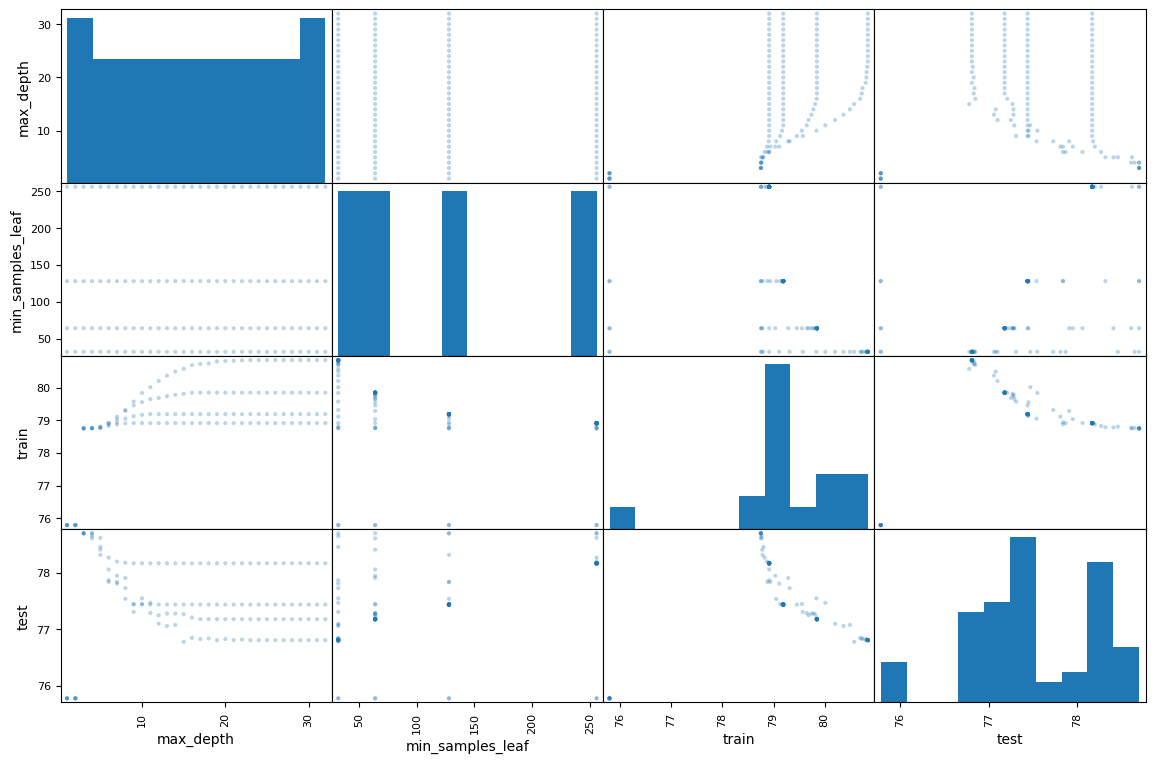

In [55]:
pd.plotting.scatter_matrix(results, figsize = (14,9), alpha = 0.3)

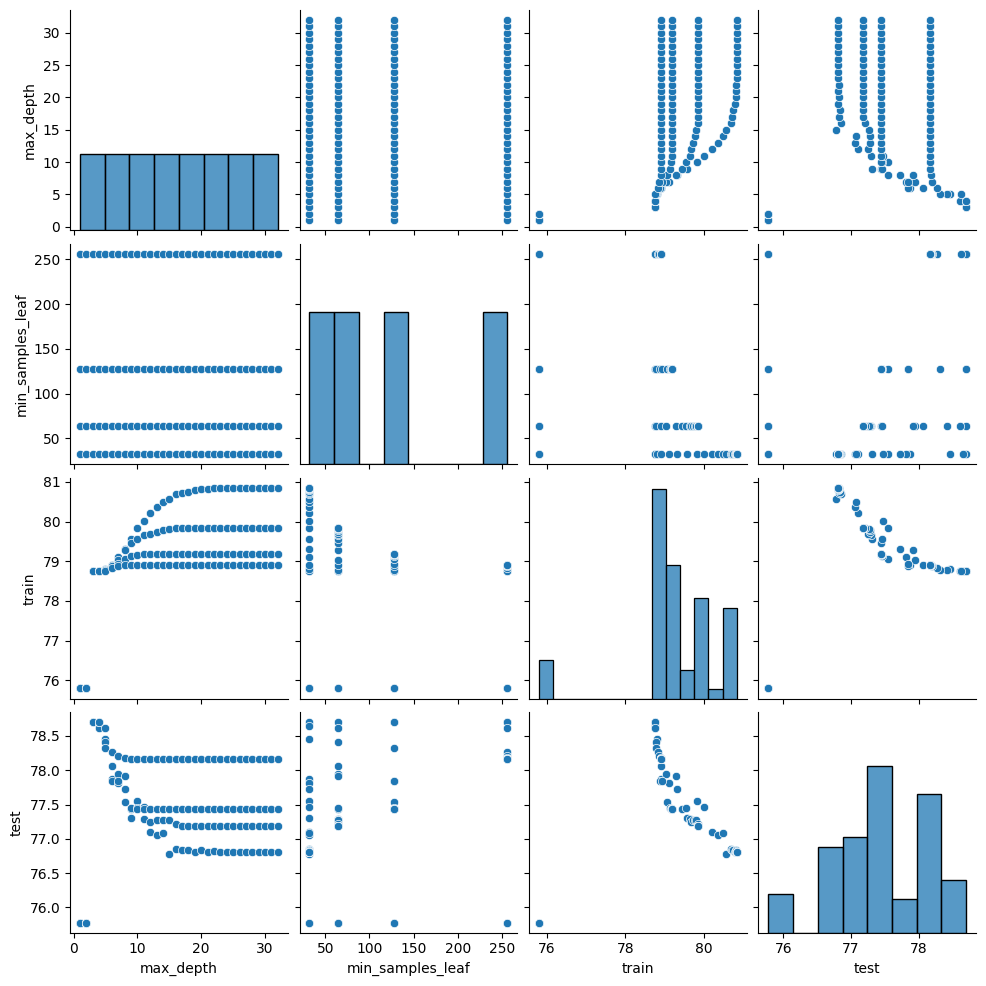

In [56]:
sns.pairplot(results)

<Axes: >

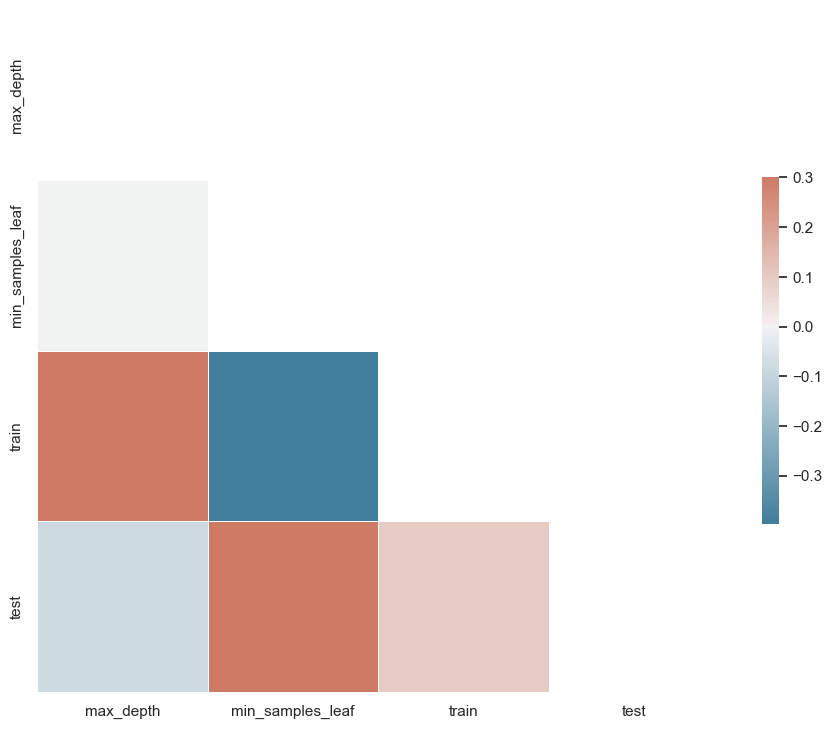

In [59]:
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = results.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [60]:
def busca():
    results = []
    for max_depth in range(1,33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            results.append(tabela)
    results = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return results

results = busca()
results.head()

Arvore max_depth = 1, Min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, Min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, Min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, Min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, Min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, Min_samples_leaf = 128, treino = 78.75, teste = 78.70
Arvore max_depth = 3, Min_samples_leaf = 192, treino = 78.75, teste = 78.70
Arvore max_depth = 3, Min_samples_leaf = 256, treino = 78.75, teste = 78.70
Arvore max_depth = 3, Min_samples_leaf = 512, treino = 77.53, teste = 77.47
Arvore max_depth = 4, Min_samples_leaf = 128, treino = 78.75, teste = 78.70
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791111,75.78
1,1,192,75.791111,75.78
2,1,256,75.791111,75.78
3,1,512,75.791111,75.78
4,2,128,75.791111,75.78


In [61]:
corr = results.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,6.863211e-17,0.353355,0.192401
min_samples_leaf,6.863211e-17,1.000000e+00,-0.631991,-0.192488
train,3.533547e-01,-6.319914e-01,1.000000,0.751503
test,1.924007e-01,-1.924883e-01,0.751503,1.000000


<Axes: >

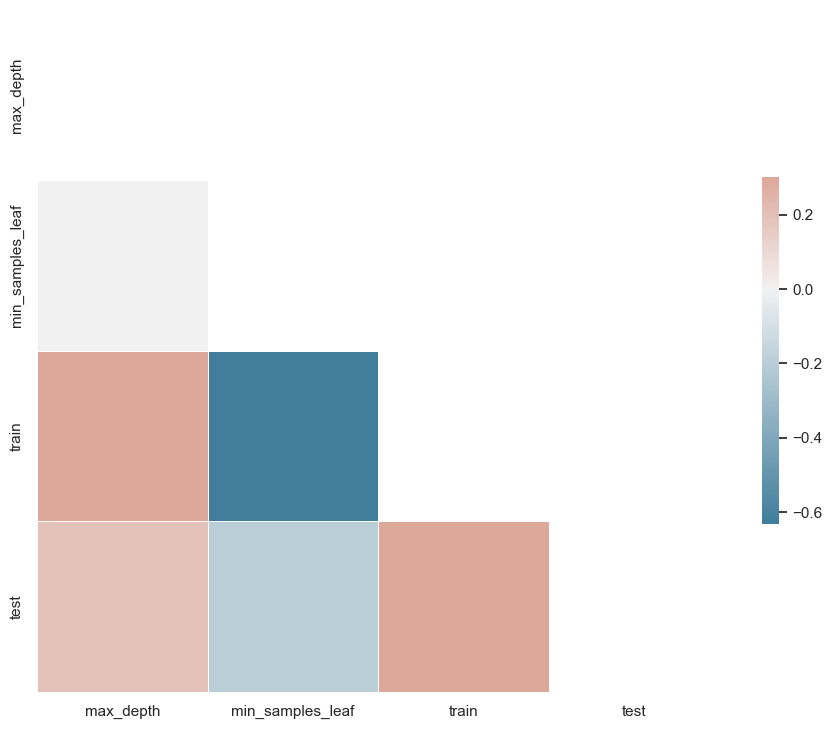

In [62]:
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = results.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [64]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.752222,78.7
10,3,256,78.752222,78.7
14,4,256,78.752222,78.7
12,4,128,78.752222,78.7
8,3,128,78.752222,78.7


## Explorando hiper parâmetros com 3 dimensões

In [70]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)


    cv = StratifiedKFold(n_splits=10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    resultados = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score= True)
    fit_time = resultados['fit_time'].mean()
    score_time = resultados['score_time'].mean()
    train_score = resultados['train_score'].mean() * 100
    test_score = resultados['test_score'].mean() * 100
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela

def busca():
    results = []
    for max_depth in range(1,33):
        for min_samples_leaf in [128, 192, 256, 512]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                results.append(tabela)
    results = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test', 'fit_time', 'score_time'])
    return results

results = busca()
results.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,128,32,75.791111,75.78,0.010784,0.004186
1,1,128,64,75.791111,75.78,0.007817,0.002787
2,1,128,128,75.791111,75.78,0.008181,0.001849
3,1,128,256,75.791111,75.78,0.007807,0.001520
4,1,192,32,75.791111,75.78,0.007188,0.001436


In [71]:
corr = results.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000e+00,-6.374867e-16,4.182375e-16,3.533547e-01,1.924007e-01,0.290018,-0.305199
min_samples_leaf,-6.374867e-16,1.000000e+00,3.977318e-18,-6.319914e-01,-1.924883e-01,-0.625099,-0.057422
min_samples_split,4.182375e-16,3.977318e-18,1.000000e+00,6.107274e-16,-1.369127e-16,-0.013078,-0.060021
train,3.533547e-01,-6.319914e-01,6.107274e-16,1.000000e+00,7.515032e-01,0.823139,-0.155886
test,1.924007e-01,-1.924883e-01,-1.369127e-16,7.515032e-01,1.000000e+00,0.388509,-0.130056
fit_time,2.900181e-01,-6.250992e-01,-1.307848e-02,8.231392e-01,3.885086e-01,1.000000,0.118980
score_time,-3.051991e-01,-5.742203e-02,-6.002091e-02,-1.558865e-01,-1.300557e-01,0.118980,1.000000


<Axes: >

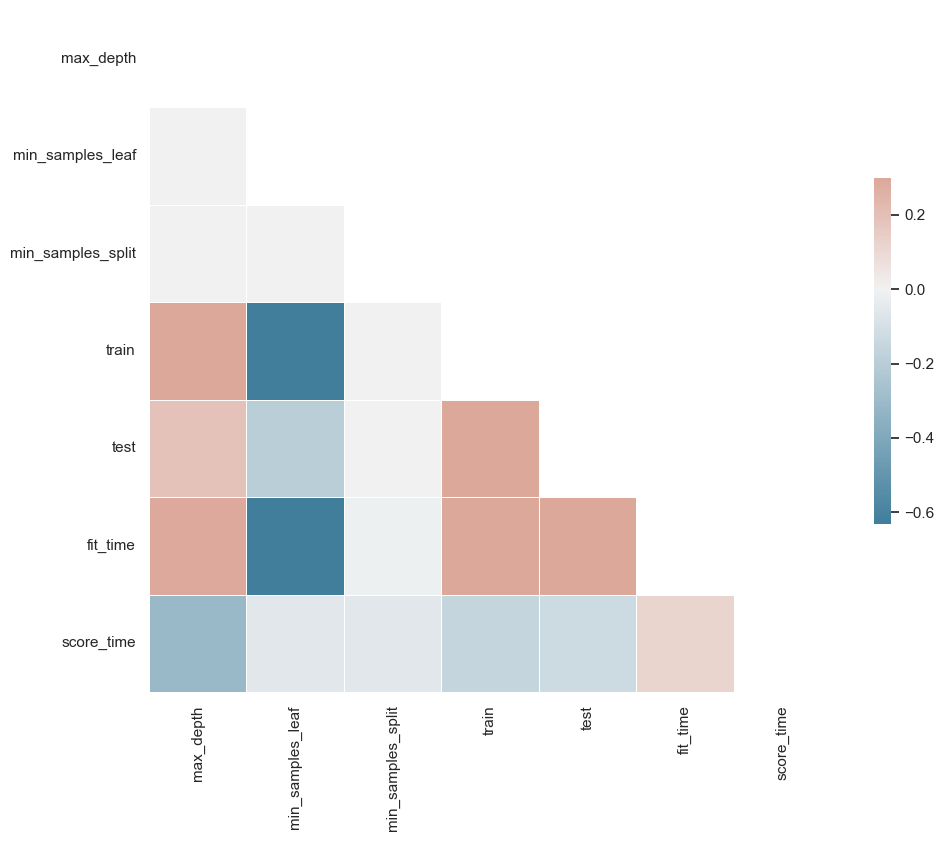

In [72]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = results.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [73]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
40,3,256,32,78.752222,78.7,0.017351,0.001392
57,4,256,64,78.752222,78.7,0.023980,0.002640
54,4,192,128,78.752222,78.7,0.021196,0.001776
53,4,192,64,78.752222,78.7,0.021412,0.001930
52,4,192,32,78.752222,78.7,0.021783,0.002099


## Explorando espaço de hiper parâmetros com GridSearchCV

In [74]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar, groups = dados.modelo)
results = pd.DataFrame(busca.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023394,0.004906,0.003314,0.001702,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.020809,0.001343,0.002052,0.000631,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.024793,0.002270,0.003195,0.001190,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.025496,0.002132,0.002866,0.000657,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.023170,0.000722,0.002260,0.000349,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [75]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [76]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [77]:
# evitar essa abordagem porque estará sendo otimista

predictions = melhor.predict(x_azar)
accuracy = accuracy_score(predictions, y_azar) * 100

print("accuracy para os dados foi %.2f%%" % accuracy)

accuracy para os dados foi 78.75%


## Como ter uma estimativa sem esse vício nos dados que eu já vi?

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation.

In [78]:
from sklearn.model_selection import cross_val_score

cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits = 10), groups = dados.modelo)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py", line 1419, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py", line 857, in evaluate_candidates
    for (cand_idx, parameters), (split_idx, (train, test)) in product(
                                                              ^^^^^^^^
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 377, in split
    for train, test in super().split(X, y, groups):
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 108, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 120, in _iter_test_masks
    for test_index in self._iter_test_indices(X, y, groups):
  File "c:\Users\Gabrielle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py", line 555, in _iter_test_indices
    raise ValueError("The 'groups' parameter should not be None.")
ValueError: The 'groups' parameter should not be None.


# Infelizmente como o Pandas não suporta nested validation com group KFold, não conseguimos prever o resultado para novos grupos.

In [81]:
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(),
                     espaco_de_parametros,
                     cv = KFold(n_splits = 5, shuffle = True))

busca.fit(x_azar, y_azar)
results = pd.DataFrame(busca.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024975,0.013280,0.002175,0.000884,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.012337,0.000841,0.001999,0.000009,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.011556,0.000467,0.001663,0.000409,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.012051,0.000787,0.001116,0.000214,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.011927,0.000490,0.001814,0.000394,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [82]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits = 5, shuffle = True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [83]:
def imprime_scores(scores):
    media = scores.mean()
    desvio_padrao = scores.std()
    print("Accuracy médio: %.2f" % (media * 100))
    print("Accuracy intervalo: [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

In [84]:
imprime_scores(scores)

Accuracy médio: 78.67
Accuracy intervalo: [76.80, 80.54]


In [85]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


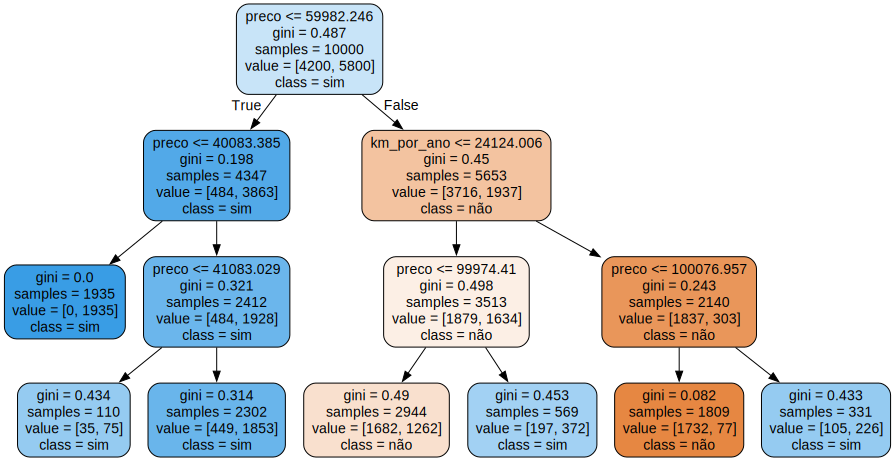

In [86]:

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                class_names=['não', 'sim'],
                feature_names= features)
graph = graphviz.Source(dot_data)
graph